In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

In [26]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_dataset = datasets.ImageFolder('data/ants_and_bees/train',
                                        transform=transform_train)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,
                                              batch_size=20,
                                              shuffle=True)

validation_dataset = datasets.ImageFolder('data/ants_and_bees/val',
                                          transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=20,
                                                shuffle=False)

In [27]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [28]:
classes=('ant','bee')

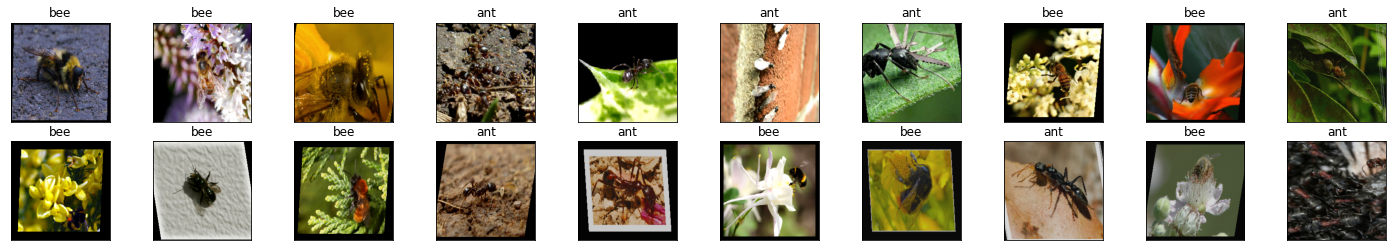

In [29]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
imgage = images.to('cpu')
labels = labels.to('cpu')
fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

In [30]:
model = models.alexnet(pretrained=True)

In [31]:
torch.manual_seed(2)
model = model.to('cpu')
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
for param in model.features.parameters():
    param.requires_grad = False

In [33]:
n_input = model.classifier[6].in_features
last_layer = nn.Linear(in_features=n_input, out_features=len(classes))
model.classifier[6] = last_layer
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [35]:
epochs = 10
running_loss_history = []
running_correct_history = []

val_running_loss_history = []
val_running_correct_history = []
for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0

    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to('cpu')
                val_labels = val_labels.to('cpu')
                #                 val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()

        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_accuracy = running_corrects.float() / len(
            training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_accuracy)
        print('Running Epoch: {}'.format(i))
        print('Training Loss: {:.4f} {:.4f}'.format(epoch_loss,
                                                    epoch_accuracy.item()))

        val_epoch_loss = running_loss / len(validation_loader.dataset)
        val_epoch_accuracy = val_running_corrects.float() / len(
            validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_accuracy)
        print('Validation Loss: {:.4f} {:.4f}'.format(
            val_epoch_loss, val_epoch_accuracy.item()))

Training Loss: 0.0267 0.7582
Validation Loss: 0.0426 0.8497
Training Loss: 0.0155 0.8770
Validation Loss: 0.0247 0.8693
Training Loss: 0.0101 0.9426
Validation Loss: 0.0161 0.9020
Training Loss: 0.0084 0.9467
Validation Loss: 0.0133 0.9085
Training Loss: 0.0066 0.9426
Validation Loss: 0.0106 0.8627
Training Loss: 0.0034 0.9877
Validation Loss: 0.0055 0.8431
Training Loss: 0.0031 0.9795
Validation Loss: 0.0050 0.8824
Training Loss: 0.0033 0.9836
Validation Loss: 0.0053 0.9020
Training Loss: 0.0035 0.9795
Validation Loss: 0.0056 0.8954
Training Loss: 0.0031 0.9877
Validation Loss: 0.0049 0.8693


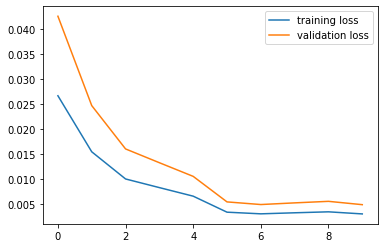

In [36]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

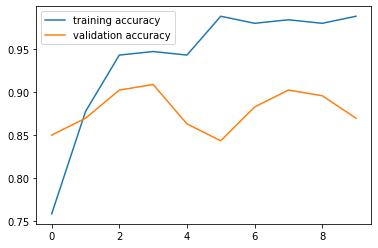

In [37]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()